## Residuals for Random forest predictions

---

In [ ]:
## load modules
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from modeling.functions import get_features
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR
from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor

## Preparation of data to perform predictions ##
Read data, linearly interpolate missing values and create dummies for cardinal wind directions. In addition, select train/validation data set and get dictionary with different feature combinations.

In [ ]:
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', \
                    parse_dates= ['TIMESTAMP'],
                    index_col= 'TIMESTAMP' )
                    
data.interpolate(method = 'linear', inplace= True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'], drop_first=True)

data_train = data[:'2013-07-01 00:00:00']
feature_dict = get_features(data)

Load .csv files with scores and information on the best feature combination for each the three best models at each zone and append 

In [ ]:
models = ['RandomForestRegressor', 'SVR', 'LGBMRegressor']
models_obj = [RandomForestRegressor(), SVR(), LGBMRegressor()]

result_df = pd.DataFrame()

for model in models:    
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    df['ZONEID'] = range(1,11)
    result_df = result_df.append(df)

## Perform predictions ##
Use the best feature combination for each model and at each zone.

In [ ]:
models_dict = {}
prediction_dict = {}
y_test_dict = {} 
X_test_dict = {}

df_results = pd.DataFrame()

for model_obj in models_obj:

    model_name = model_obj.__class__.__name__
    
    models_dict[model_name] = {}
    prediction_dict[model_name] = {}
    X_test_dict[model_name] = {}
    y_test_dict[model_name] = {}

    for zone in result_df.ZONEID.unique():

        fc = result_df[(result_df.ZONEID == zone) & (result_df.MODEL == model_name)]['FC'].values[0]
        
        data_train_zone = data_train[data_train.ZONEID == zone]
        
        X_train = data_train_zone[feature_dict[fc]]
        y_train = data_train_zone.TARGETVAR
    
        best_params = result_df[(result_df.ZONEID == zone) & (result_df.MODEL == model_name)]['BEST_PARAMS'].values[0]
        model = model_obj.set_params(**ast.literal_eval(best_params))

        y_pred = cross_val_predict(model, X_train, y_train, cv=5)
        y_pred = np.array([1 if value >= 1 else 0 if value <= 0 else value for value in y_pred])
        
        tmp_df = deepcopy(data_train_zone)
        tmp_df['MODEL'] = model_name
        tmp_df['PRED'] = y_pred
        tmp_df['RESIDUAL'] = tmp_df.PRED - tmp_df.TARGETVAR

        df_results = df_results.append(tmp_df)
        
        prediction_dict[model_name][zone] = y_pred
        models_dict[model_name][zone] = deepcopy(model)

Define bins for predicted wind energy production and predicted wind speed.

In [ ]:
pred_bins = [round(x, 2) for x in np.arange(0, 1.01, 0.05)]
pred_labels = []
for i, bin_ in enumerate(pred_bins):
    if i > len(pred_bins) - 2:
        break
    pred_labels.append(f'{bin_:.2f}-{pred_bins[i + 1]:.2f}')

ws_bins = [round(x, 2) for x in np.arange(0, 25, 2)]
ws_labels = []
for i, bin_ in enumerate(ws_bins):
    if i > len(ws_bins) - 2:
        break
    ws_labels.append(f'{bin_}-{ws_bins[i + 1]}')

df_results['PRED_BIN'] = pd.cut(df_results['PRED'], bins = pred_bins, labels=pred_labels)
df_results['WS100_BIN'] = pd.cut(df_results['WS100'], bins = ws_bins, labels=ws_labels)

## Plot residuals for Random forest

In [ ]:
df_results = df_results[df_results.MODEL == 'RandomForestRegressor']

Residuals of predicted energy production by predicted energy production. Aggregated over all wind farms and for each wind farm individually.

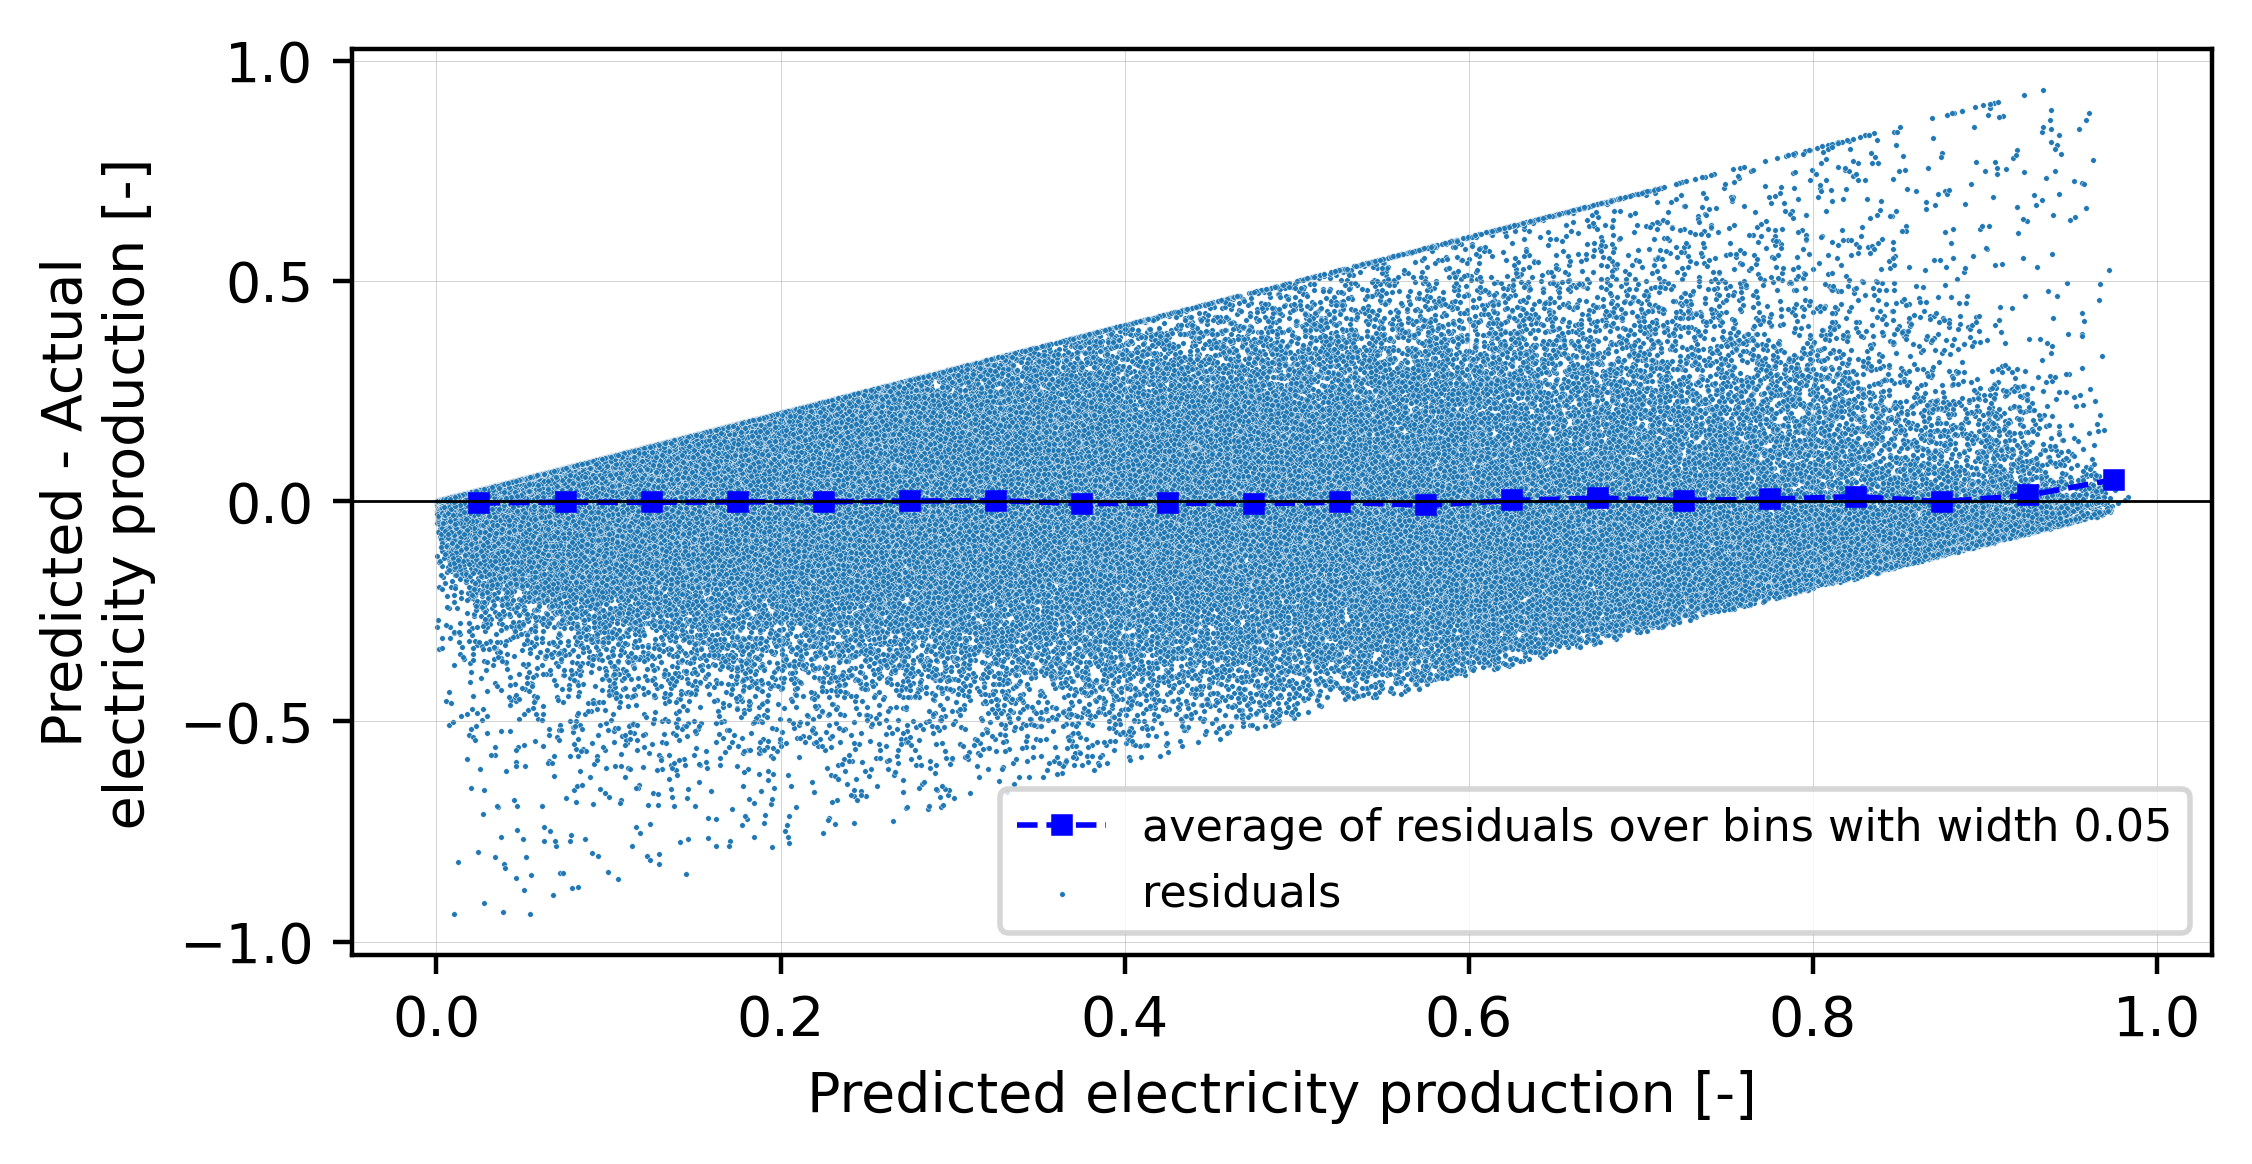

In [14]:
bias = df_results.groupby(by = 'PRED_BIN').mean()['RESIDUAL'] 
fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(.025,1.00,.05), bias.values, linewidth=1, linestyle='--', marker='s', markersize=3, color='b', label='average of residuals over bins with width 0.05')
scatter = sns.scatterplot(data = df_results, x = 'PRED', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production [-]');
ax.set_xlabel('Predicted electricity production [-]');
ax.axhline(color = 'k', linewidth = 0.5)
ax.legend(fontsize=8)
fig.savefig('../images/Residuals-By-PredEnergy_RandomForest_Aggregated.png')

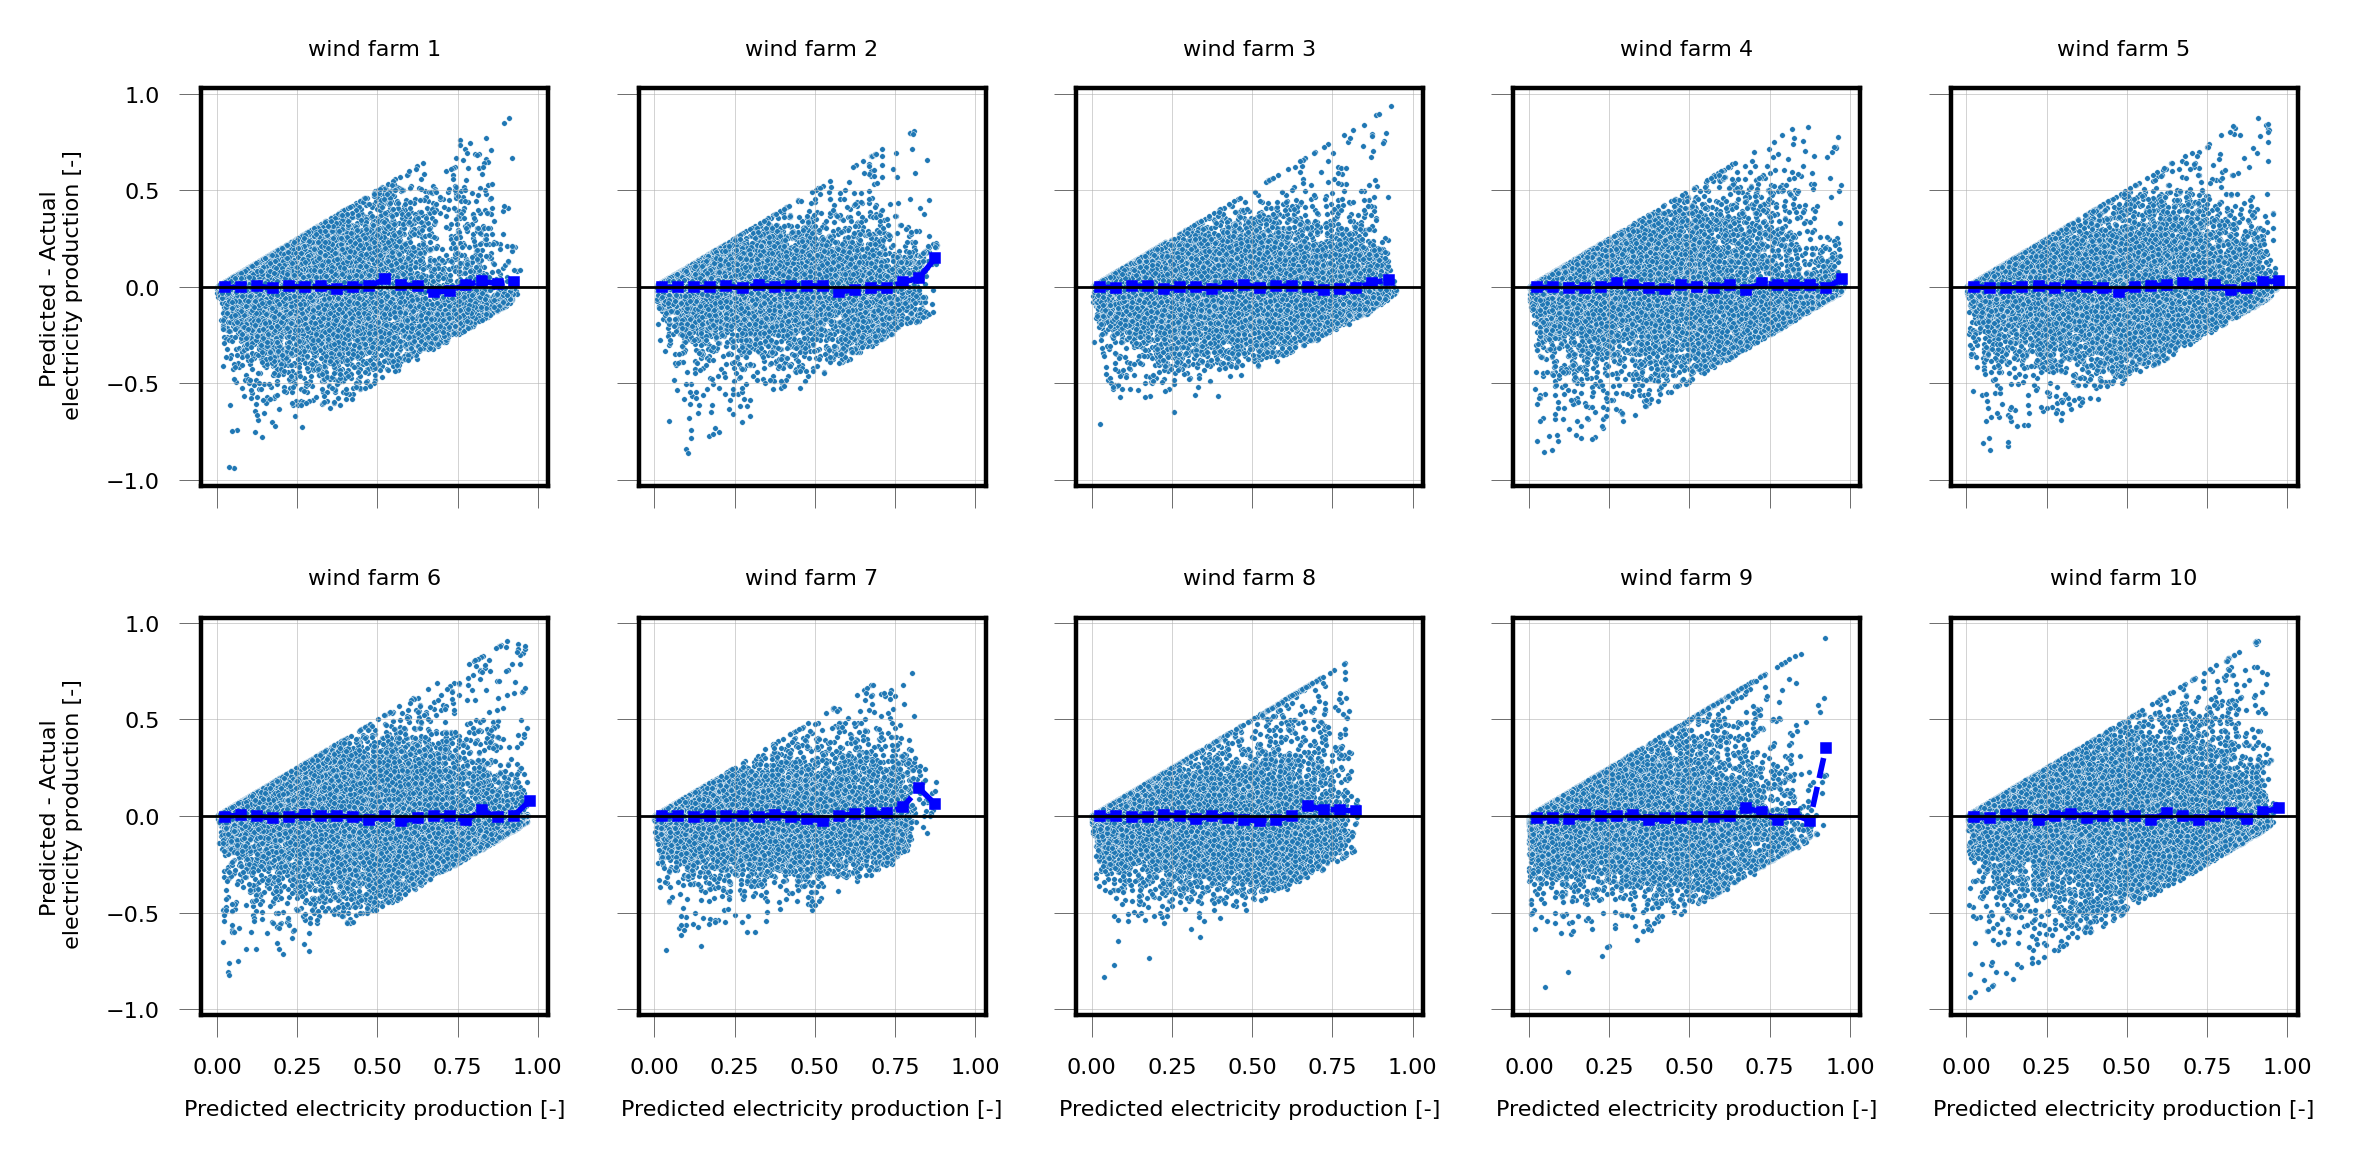

In [15]:
fig,ax = plt.subplots(nrows=2, ncols=5, dpi=400, figsize=(6,3), sharex=True, sharey=True)
ax = ax.ravel()

for i,zone in enumerate(df_results.ZONEID.unique()):

    bias = df_results[df_results.ZONEID==zone].groupby(by = 'PRED_BIN').mean()['RESIDUAL'] 

    ax[i].plot(np.arange(.025,1.00,.05), bias.values, linewidth=1, linestyle='--', marker='s', markersize=1, color='b')
    scatter = sns.scatterplot(data = df_results[df_results.ZONEID==zone], x = 'PRED', y = 'RESIDUAL', s=1, ax=ax[i])
    ax[i].grid(linewidth=.1)
    ax[i].set_xlabel(None) 
    ax[i].set_ylabel(None) 

    if i in [0,5]:
        ax[i].set_ylabel('Predicted - Actual\n electricity production [-]', fontsize=4)

    if i > 4:
        ax[i].set_xlabel('Predicted electricity production [-]', fontsize=4);
   
    ax[i].axhline(color = 'k', linewidth = 0.5)
    ax[i].set_title("{} {}".format('wind farm',zone), fontsize=4)
    ax[i].tick_params(axis='both', size=4, labelsize=4, width=.1, length=.01)
fig.tight_layout()
fig.savefig('../images/Residuals-By-PredEnergy_RandomForest_ByWindfarms.png')

Residuals of predicted energy production by predicted wind speed in 100 meter above ground. Aggregated over all wind farms.

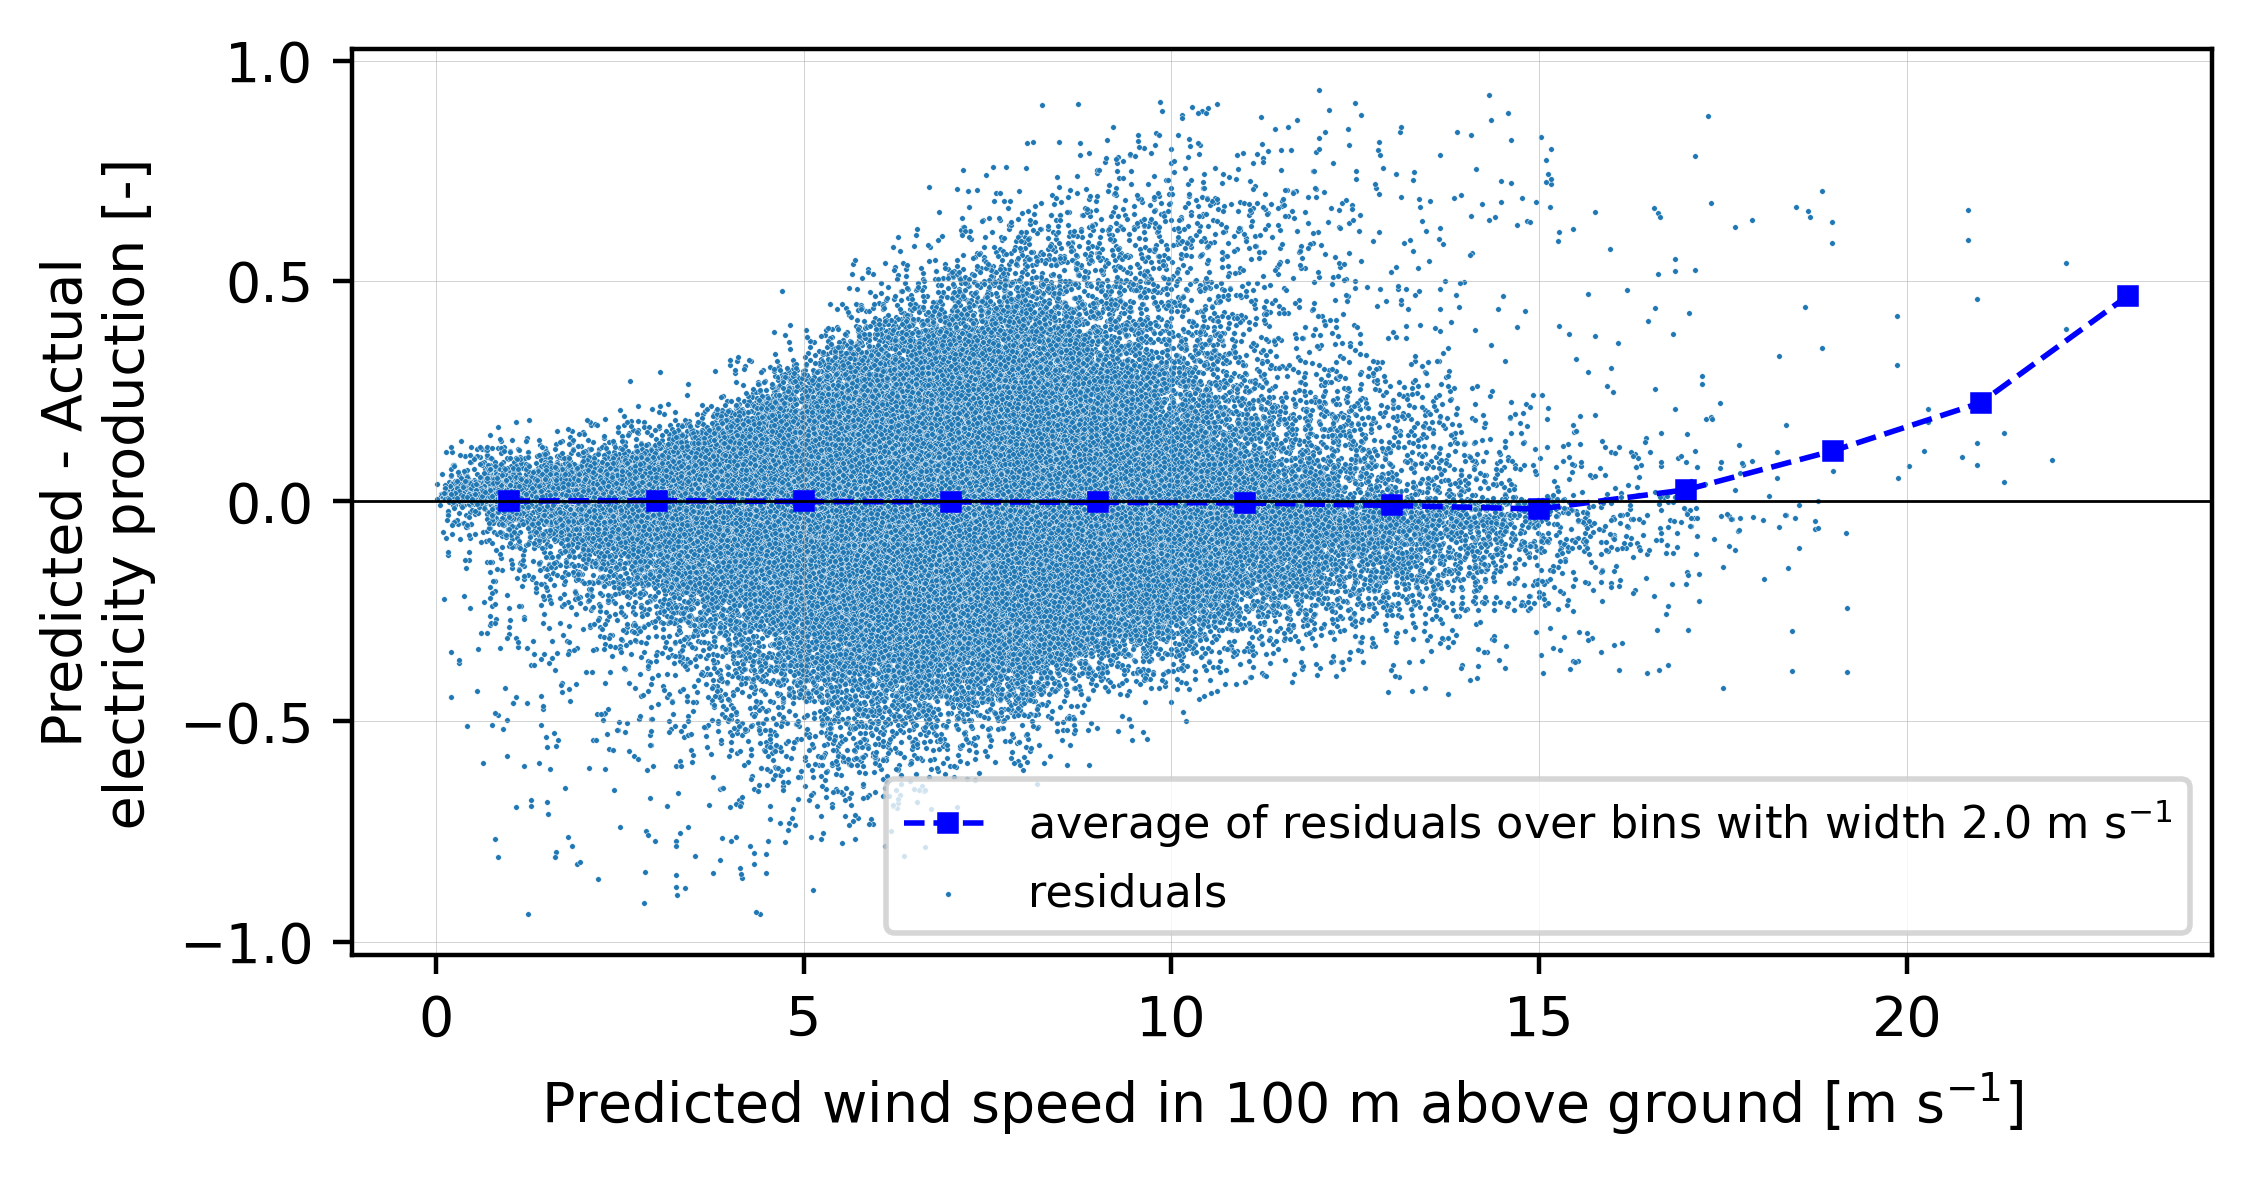

In [16]:
bias = df_results.groupby(by = 'WS100_BIN').mean()['RESIDUAL']

fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(1,25,2), bias.values, linewidth=1, linestyle='--', marker='s', markersize=3, color='b', label='average of residuals over bins with width 2.0 $\mathregular{m\ s^{-1}}$')
scatter = sns.scatterplot(data = df_results, x = 'WS100', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production [-]');
ax.set_xlabel('Predicted wind speed in 100 m above ground [$\mathregular{m\ s^{-1}}$]');
ax.axhline(color = 'k', linewidth = 0.5)
ax.legend(fontsize=8);
fig.savefig('../images/Residuals-By-PredWS100_RandomForest_Aggregated.png')